In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import time

device = torch.device('cpu')

In [2]:
epochs = 800
lr = 3e-5
block_size = 30

In [3]:
d, m, k = 1000, 1000, 50

A = torch.randn(d, m, device=device)
X = torch.randn(d, k, device=device)
E = torch.randn(m, k, device=device)

noised_matrix = torch.mm(A, X) + E

In [4]:
b_i = torch.argmax(noised_matrix, dim=1)

Z = torch.zeros(d, k, device=device)
Z[torch.arange(d), b_i] = 1

In [5]:
def f(X, A, b_i):
    logits = torch.mm(A, X)
    log_probs = -F.log_softmax(logits, dim=1)
    loss = (log_probs * Z).sum() / Z.sum()
    return loss

def P(X, A):
    return F.softmax(torch.mm(A, X), dim = 1)

def gradient(X, A, Z):
    logits = torch.mm(A, X)
    probs = F.softmax(logits, dim=1)
    grad = torch.mm(A.t(), probs - Z)
    return grad

In [6]:
def evaluate_accuracy(X, A, b_i):
    with torch.no_grad():
        logits = torch.mm(A, X)
        predictions = torch.argmax(logits, dim=1)
        accuracy = (predictions == b_i).float().mean().item()
    return accuracy

In [7]:
def GD(X, A, Z, b_i, epochs, lr):
    losses = []
    accuracies = []
    times = []
    start_time = time.time()
    for epoch in range(epochs):
        update = gradient(X, A, Z)
        X -= lr * update
        loss = f(X, A, Z)
        current_time = time.time() - start_time
        accuracy = evaluate_accuracy(X, A, b_i)
        
        losses.append(loss.item())
        accuracies.append(accuracy)
        times.append(current_time)
    return losses, accuracies, times


In [8]:
def BCGD_randomized(X, A, Z, b_i, epochs, lr, block_size):
    losses = []
    accuracies = []
    times = []
    start_time = time.time()
    for epoch in range(epochs):
        block_indices = torch.randint(0, X.shape[1], (block_size,)).tolist()
        update_block = gradient(X[:, block_indices], A, Z[:, block_indices])
        X[:, block_indices] -= lr * update_block
        loss = f(X, A, Z)
        current_time = time.time() - start_time
        accuracy = evaluate_accuracy(X, A, b_i)
        
        losses.append(loss.item())
        accuracies.append(accuracy)
        times.append(current_time)
    return losses, accuracies, times


In [9]:
def BCGD_Gauss_Southwell(X, A, Z, b_i, epochs, lr, block_size):
    losses = []
    accuracies = []
    times = []
    start_time = time.time()
    for epoch in range(epochs):
        norms = torch.norm(gradient(X, A, Z), dim=0)
        _, block_indices = torch.topk(norms, block_size, largest=True)
        update_block = gradient(X[:, block_indices], A, Z[:, block_indices])
        X[:, block_indices] -= lr * update_block
        loss = f(X, A, Z)
        current_time = time.time() - start_time
        accuracy = evaluate_accuracy(X, A, b_i)
        
        losses.append(loss.item())
        accuracies.append(accuracy)
        times.append(current_time)
    return losses, accuracies, times

In [10]:
def plot_results_combined(times_gd, accuracies_gd, losses_gd,
                          times_bcgd_random, accuracies_bcgd_random, losses_bcgd_random,
                          times_bcgd_gs, accuracies_bcgd_gs, losses_bcgd_gs):
    plt.figure(figsize=(10, 10))


    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(times_gd, accuracies_gd, 'r-', label='GD')
    ax1.plot(times_bcgd_random, accuracies_bcgd_random, 'g-', label='BCGD Randomized')
    ax1.plot(times_bcgd_gs, accuracies_bcgd_gs, 'b-', label='BCGD Gauss-Southwell')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Accuracy vs. CPU Time')
    ax1.legend()


    ax2 = plt.subplot(2, 1, 2)
    ax2.plot(times_gd, losses_gd, 'r--', label='GD Loss')
    ax2.plot(times_bcgd_random, losses_bcgd_random, 'g--', label='BCGD Randomized Loss')
    ax2.plot(times_bcgd_gs, losses_bcgd_gs, 'b--', label='BCGD Gauss-Southwell Loss')
    ax2.set_ylabel('Loss')
    ax2.set_title('Loss vs. CPU Time')
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [11]:
losses_gd, accuracies_gd, times_gd = GD(X.clone(), A, Z, b_i, epochs, lr)
losses_bcgd_random, accuracies_bcgd_random, times_bcgd_random = BCGD_randomized(X.clone(), A, Z, b_i, epochs, lr, block_size)
losses_bcgd_gs, accuracies_bcgd_gs, times_bcgd_gs = BCGD_Gauss_Southwell(X.clone(), A, Z, b_i, epochs, lr, block_size)

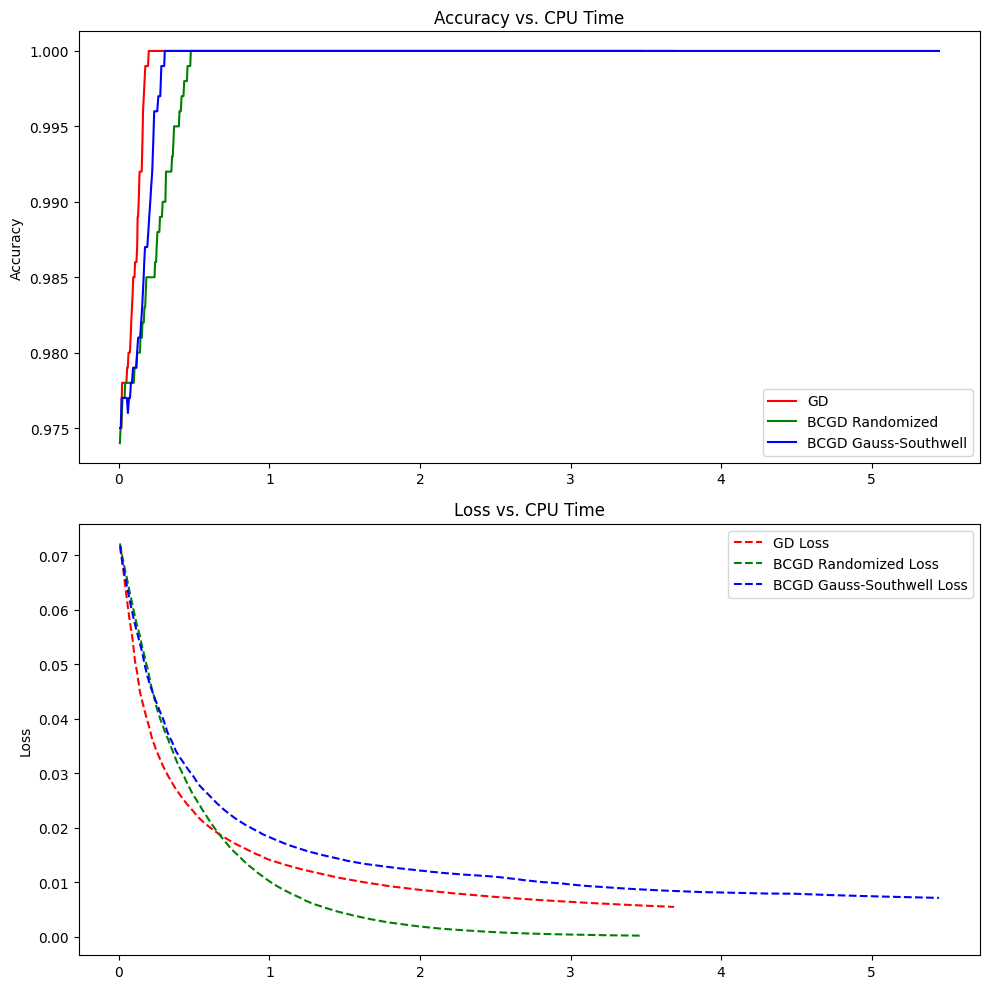

In [12]:
plot_results_combined(times_gd, accuracies_gd, losses_gd,
                      times_bcgd_random, accuracies_bcgd_random, losses_bcgd_random,
                      times_bcgd_gs, accuracies_bcgd_gs, losses_bcgd_gs)

In [13]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)


def get_full_mnist_dataset(loader):
    for images, b_i in loader:
        return images.view(images.shape[0], -1).to(device), b_i.to(device)

A, Y = get_full_mnist_dataset(train_loader)
k = 10
d, m = A.shape

X = torch.randn(k, m, device=device)
E = torch.randn(d, k, device=device)


Z = F.one_hot(Y, num_classes=k).float().to(device)


def f(X, A, Z):
    logits = torch.mm(A, X.t())
    log_probs = -F.log_softmax(logits, dim=1)
    loss = (log_probs * Z).sum() / Z.sum()
    return loss


def gradient(X, A, Z):
    logits = torch.mm(A, X.t())
    probs = F.softmax(logits, dim=1)
    grad = torch.mm(A.t(), (probs - Z))
    return grad.t()


def evaluate_accuracy(X, A, b_i):
    with torch.no_grad():
        logits = torch.mm(A, X.t())
        predictions = torch.argmax(logits, dim=1)
        accuracy = (predictions == b_i).float().mean().item()
    return accuracy

In [14]:
epochs_MNIST = 1200
lr_MNIST = 3e-5
block_size_MNIST = 9

In [15]:
def GD(X, A, Z, epochs_MNIST, lr_MNIST, b_i):
    losses = []
    accuracies = []
    times = []
    start_time = time.time()
    for epoch in range(epochs_MNIST):
        update = gradient(X, A, Z)
        X -= lr_MNIST * update
        loss = f(X, A, Z)
        current_time = time.time() - start_time
        accuracy = evaluate_accuracy(X, A, b_i)
        
        losses.append(loss.item())
        accuracies.append(accuracy)
        times.append(current_time)
    return losses, accuracies, times


def BCGD_randomized(X, A, Z, epochs_MNIST, lr_MNIST, block_size_MNIST, b_i):
    losses = []
    accuracies = []
    times = []
    start_time = time.time()
    k, m = X.shape
    for epoch in range(epochs_MNIST):
        block_indices = torch.randint(0, k, (block_size_MNIST,))
        update_block = gradient(X[block_indices, :], A, Z[:, block_indices])
        X[block_indices, :] -= lr_MNIST * update_block
        loss = f(X, A, Z)
        current_time = time.time() - start_time
        accuracy = evaluate_accuracy(X, A, b_i)
        
        losses.append(loss.item())
        accuracies.append(accuracy)
        times.append(current_time)
    return losses, accuracies, times


def BCGD_Gauss_Southwell(X, A, Z, epochs_MNIST, lr_MNIST, block_size_MNIST, b_i):
    losses = []
    accuracies = []
    times = []
    start_time = time.time()
    k, m = X.shape
    block_size = min(block_size_MNIST, k)
    for epoch in range(epochs_MNIST):
        grad_full = gradient(X, A, Z)
        norms = torch.norm(grad_full, dim=1)
        _, block_indices = torch.topk(norms, block_size, largest=True)
        update_block = gradient(X[block_indices, :], A, Z[:, block_indices])
        X[block_indices, :] -= lr_MNIST * update_block
        loss = f(X, A, Z)
        current_time = time.time() - start_time
        accuracy = evaluate_accuracy(X, A, b_i)
        
        losses.append(loss.item())
        accuracies.append(accuracy)
        times.append(current_time)
    return losses, accuracies, times


In [16]:
def plot_results_combined(times_gd, accuracies_gd, losses_gd,
                          times_bcgd_random, accuracies_bcgd_random, losses_bcgd_random,
                          times_bcgd_gs, accuracies_bcgd_gs, losses_bcgd_gs):
    plt.figure(figsize=(10, 10))


    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(times_gd, accuracies_gd, 'r-', label='GD')
    ax1.plot(times_bcgd_random, accuracies_bcgd_random, 'g-', label='BCGD Randomized')
    ax1.plot(times_bcgd_gs, accuracies_bcgd_gs, 'b-', label='BCGD Gauss-Southwell')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Accuracy vs. CPU Time')
    ax1.legend()


    ax2 = plt.subplot(2, 1, 2)
    ax2.plot(times_gd, losses_gd, 'r--', label='GD Loss')
    ax2.plot(times_bcgd_random, losses_bcgd_random, 'g--', label='BCGD Randomized Loss')
    ax2.plot(times_bcgd_gs, losses_bcgd_gs, 'b--', label='BCGD Gauss-Southwell Loss')
    ax2.set_ylabel('Loss')
    ax2.set_title('Loss vs. CPU Time')
    ax2.legend()

    plt.tight_layout()
    plt.show()


In [17]:
losses_gd, accuracies_gd, times_gd = GD(X.clone(), A, Z, epochs_MNIST, lr_MNIST, Y)
losses_bcgd_random, accuracies_bcgd_random, times_bcgd_random = BCGD_randomized(X.clone(), A, Z, epochs_MNIST, lr_MNIST, block_size_MNIST, Y)
losses_bcgd_gs, accuracies_bcgd_gs, times_bcgd_gs = BCGD_Gauss_Southwell(X.clone(), A, Z, epochs_MNIST, lr_MNIST, block_size_MNIST, Y)

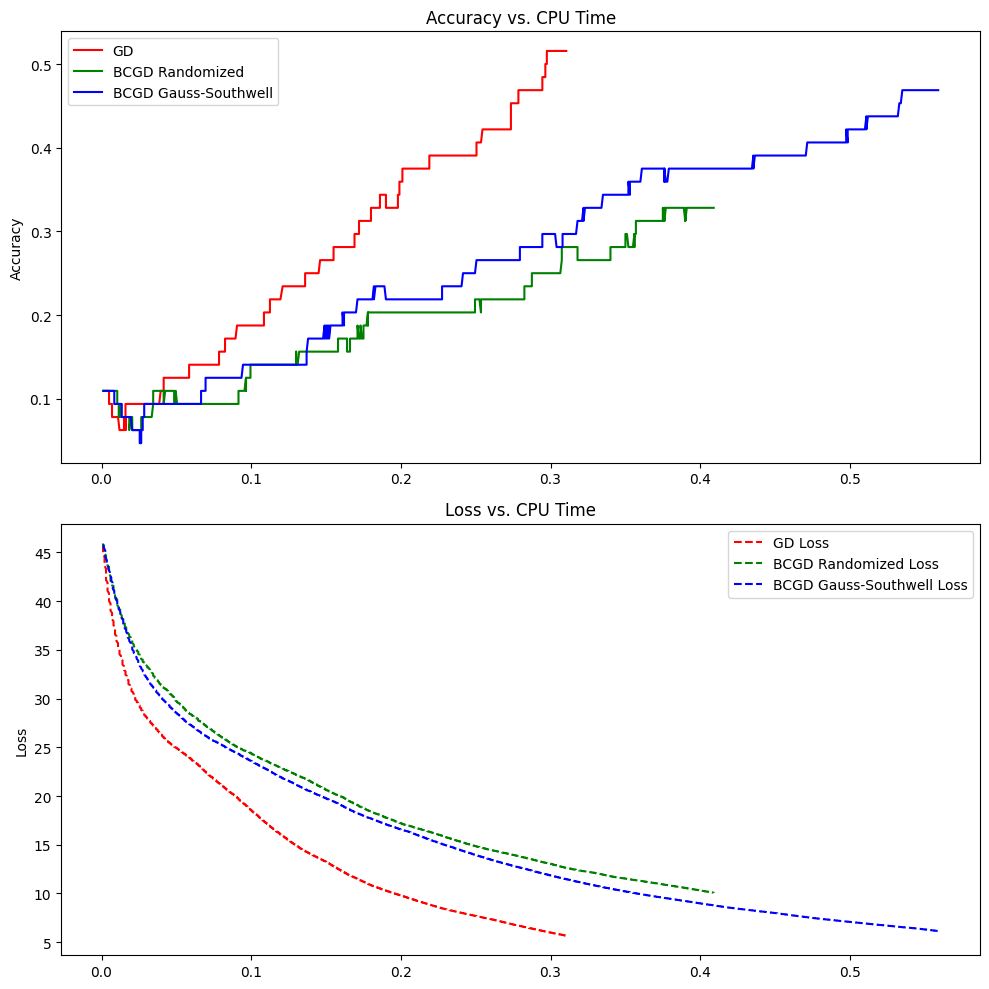

In [18]:

plot_results_combined(times_gd, accuracies_gd, losses_gd,
                      times_bcgd_random, accuracies_bcgd_random, losses_bcgd_random,
                      times_bcgd_gs, accuracies_bcgd_gs, losses_bcgd_gs)
